In [70]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [38]:
#reading in necessary csv files
df_users=pd.read_csv('takehome_users.csv',encoding='latin-1')
df_eng=pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [39]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [40]:
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### 1.Data Wrangling

In [41]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [45]:
df_users['creation_time']=pd.to_datetime(df_users['creation_time'])
df_users['last_session_creation_time']=pd.to_datetime(df_users['last_session_creation_time'])

In [42]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [46]:
df_eng['time_stamp']=pd.to_datetime(df_eng['time_stamp'])

### 2. To find Adopted users
Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .


In [47]:
#reformatting table
temp=pd.pivot_table(df_eng, values='visited', index=['user_id', 'time_stamp'])

In [48]:
#getting largest number of logins in per week for each user through reformating
#resampling of multiindex for every 2 weeks
level_values = temp.index.get_level_values
temp_2 = (temp.groupby([level_values(i) for i in [0,1]] +[pd.Grouper(freq='1w', level=-1)])).count()

#formatting
temp_2=temp_2.reset_index(level=1)
temp_2=temp_2.drop(['time_stamp'],axis=1)
temp_2=temp_2.reset_index()

#grouping by user_id and timestamp and formatting to take max
temp_3=temp_2.groupby(['user_id','time_stamp']).sum()
temp_3=temp_3.reset_index()
temp_3=temp_3.groupby('user_id').max()
final=temp_3.drop('time_stamp',axis=1)
final=final.reset_index()

In [49]:
final.head()

,user_id,visited
0,1,1
1,2,3
2,3,1
3,4,1
4,5,1


In [50]:
#merging two datasets
total_df=users.merge(final, how='left',  left_on='object_id', right_on='user_id')
total_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,3.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5.0,1.0


In [51]:
total_df=total_df.drop(['user_id'],axis=1)

In [52]:
total_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,3.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0


In [53]:
total_df['adopted_user']=total_df.visited>=3

In [54]:
total_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,3.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,False


In [58]:
adopted_users=total_df.groupby('adopted_user').count()['object_id']

In [64]:
adopted_users[0]/sum(adopted_users)*100


87.95833333333334

In [63]:
adopted_users[1]/sum(adopted_users)

0.12041666666666667

###### Approximately 88% of the users are Non-adopted users, While rest of the 12% are Adopted users. We can do a lot to increase the amount of Non-adopted users.

In [88]:
total_df_up=total_df.drop(['object_id','name','email','creation_time','visited','invited_by_user_id'],axis=1)
total_df_up['last_session_creation_time'] = total_df_up['last_session_creation_time'].fillna(total_df_up['last_session_creation_time'].mean())
total_df_up.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user
0,GUEST_INVITE,1.398139e+09,1,0,11,False
1,ORG_INVITE,1.396238e+09,0,0,1,True
2,ORG_INVITE,1.363735e+09,0,0,94,False
3,GUEST_INVITE,1.369210e+09,0,0,1,False
4,GUEST_INVITE,1.358850e+09,0,0,193,False


In [89]:
total_df_up.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   last_session_creation_time  12000 non-null  float64
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   org_id                      12000 non-null  int64  
 5   adopted_user                12000 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(1)
memory usage: 894.2+ KB


### 3. Machine Learning

In [90]:
total_df_up['last_session_creation_time'] = total_df_up['last_session_creation_time'].fillna(total_df_up['last_session_creation_time'].mean())
y=total_df_up['adopted_user'].values
df_x=total_df_up.drop(['adopted_user'],axis=1)
df_x=pd.get_dummies(df_x,drop_first=False)

X=df_x.values
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y)

In [91]:
total_df_up.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   last_session_creation_time  12000 non-null  float64
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   org_id                      12000 non-null  int64  
 5   adopted_user                12000 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(1)
memory usage: 894.2+ KB


In [101]:
rfc = RandomForestClassifier()
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.92555556 0.92166667 0.93055556 0.92       0.92555556]
Average 5-Fold CV Score: 0.9246666666666666


In [102]:
rfc.fit(X_train, y_train)
# predict using model
y_predict = rfc.predict(X_test)

In [103]:


# evaluate model prediction performance 
print ('Test set performance:')
print ('Accuracy: ', accuracy_score(y_test,y_predict))
print (classification_report(y_test, y_predict))

Test set performance:
Accuracy:  0.9313333333333333
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      2639
        True       0.76      0.63      0.69       361

    accuracy                           0.93      3000
   macro avg       0.85      0.80      0.82      3000
weighted avg       0.93      0.93      0.93      3000



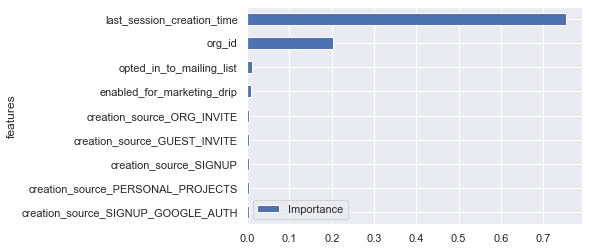

In [113]:
Key_features = pd.DataFrame(list(zip(df_x.columns, rfc.feature_importances_)), columns = ['features', 'Importance'])
Key_features.set_index('features',inplace=True)
Key_features.sort_values(by='Importance').plot(kind='barh')

### 4.Conclusion

<br>1.Approximately 88% of the users are Non-adopted users, While rest of the 12% are Adopted users. We can do a lot to increase the amount of Non-adopted users.
<br>2.<b>Last_session_creation_time</b> is the most important feature to look for when checking for the best feature with above 0.7 on our importance scale
<br>3.<b>Org_id</b> comes as 2nd with a importance score of 0.2
<br>4.No other feature comes  as important as the above two features